# Vibration Compensation

#### Problem:  Vehicle platform oscillates at frequency higher than period of LIDAR scan

At the same time, we need the full convex hull of a LIDAR scan to "guarentee" convergence


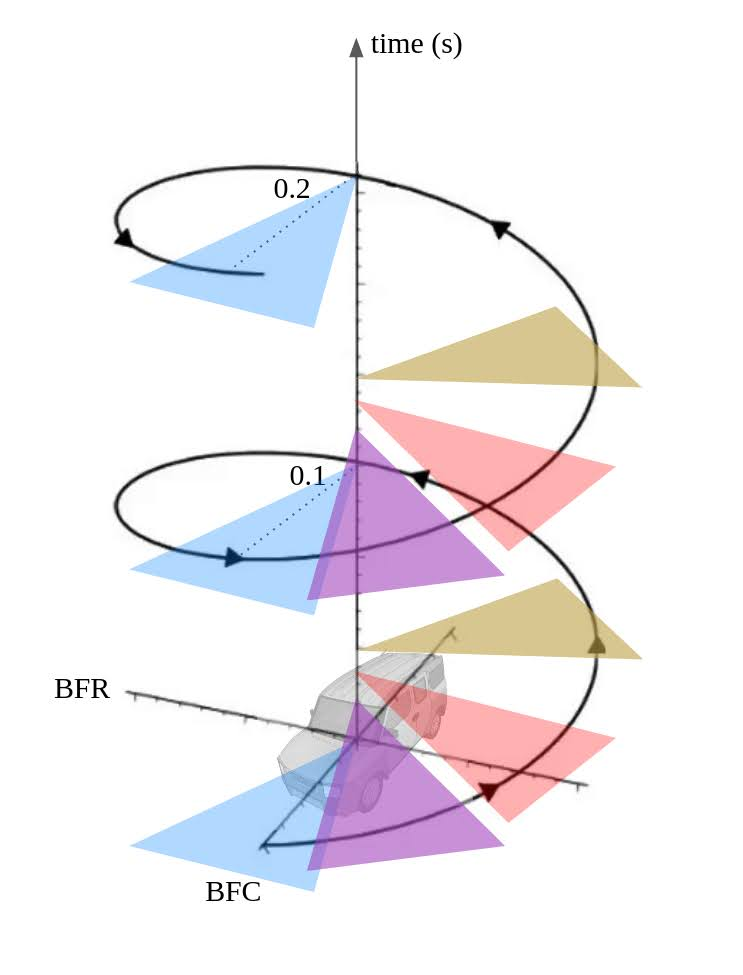

### Goal: find registrations that best align slices of matching colors

### Use ICET to register sequential "timed" slices, apply smoothing operation to constrain neighboring angular slices 

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-03-02 19:41:49.796529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 19:41:49.891172: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-02 19:41:50.272370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-02 19:41:50.272421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-02 19:41:50.814567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 19:41:50.815269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 19:41:50.815438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 19:41:50.815558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


### Import dataset

In [2]:
# #big hill and church:
drive = "20200721_144638_part36_1956_2229"

# # straight road, narrow with pedestrians and shops 
# drive = "20200617_191627_part12_1614_1842"

#suburban neighborhood, trees, houses and parked cars
# drive = "20200706_161206_part22_670_950"

In [100]:
dataset_path = "/media/derm/06EF-127D3/leddartech/" + drive
config_path = "/media/derm/06EF-127D3/leddartech/" + drive + "/platform.yml"
pf = Platform(dataset_path, config_path)

idx = 100 #turn
skips = 1
undistort = False
# undistort = True

data1 = pf['ouster64_bfc_xyzit'][idx].get_point_cloud(undistort = undistort)
lidar_time1 = pf['ouster64_bfc_xyzit'][idx].get_field('t')
lidar_time1 = lidar_time1 - lidar_time1[0]
lidar_time1 = np.asarray(lidar_time1 / max(lidar_time1))
data1 = np.asarray(data1.tolist())[:,:3]

data2 = pf['ouster64_bfc_xyzit'][idx+skips].get_point_cloud(undistort = undistort)
lidar_time2 = pf['ouster64_bfc_xyzit'][idx+skips].get_field('t')
lidar_time2 = lidar_time2 - lidar_time2[0]
lidar_time2 = np.asarray(lidar_time2 / max(lidar_time2))
data2 = np.asarray(data2.tolist())[:,:3]

Loading sensors: 100%|████████████████████████████| 9/9 [00:00<00:00, 66.46it/s]


# Get (distorted) gross transform by applying ICET to entire point clouds

In [101]:
binsize = 100
it = ICET(cloud1 = data1, cloud2 = data2, fid = binsize, niter = 10, 
           draw = True, group = 2, RM = True, DNN_filter = False)#, cheat = x0)
ViewInteractiveWidget(it.plt.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,



 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.57540715 -0.03008761 -0.02127653 -0.00268504  0.00794399 -0.0064861 ], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [127]:
#now just look at a few azimutal bins at a time
horizontal_bins_per_slice = 10 #5
num_azim_bins = binsize // horizontal_bins_per_slice

plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

scan1_slices = []
scan2_slices = []

stepsize = 2*np.pi / num_azim_bins
lower_bound = -np.pi
upper_bound = lower_bound + stepsize
for a in range(num_azim_bins):
# for a in range(num_azim_bins - 5): #debug
#     print("\n lower_bound:", lower_bound,"upper_bound:", upper_bound)
    #get points in slice from cloud1 
    S1 = it.cloud1_tensor_spherical[it.cloud1_tensor_spherical[:,1] > lower_bound]
    S1 = S1[S1[:,1] < upper_bound]
    S1 = it.s2c(S1)
    scan1_slices.append(S1)
    
    S2 = it.cloud2_tensor_spherical[it.cloud2_tensor_spherical[:,1] > lower_bound]
    S2 = S2[S2[:,1] < upper_bound]
    S2 = it.s2c(S2)
    scan2_slices.append(S2)
    disp.append(Points(S2, c = (np.random.rand(), np.random.rand(), np.random.rand())))
    
    lower_bound = upper_bound
    upper_bound += stepsize

plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [128]:
#store registration estimates and pred stds for a single scan pair
traj_hist_scans_ij = np.zeros([len(scan1_slices),6])
pred_stds_scans_ij = np.zeros([len(scan1_slices),6])

for s in range(len(scan1_slices)):
    c1 = scan1_slices[s]
    c2 = scan2_slices[s]
    
    try:
        ICET_output = ICET(cloud1 = c1, cloud2 = c2, fid = binsize, niter = 10, 
                           draw = False, group = 2, RM = True, DNN_filter = False)
        traj_hist_scans_ij[s] = ICET_output.X
        pred_stds_scans_ij[s] = ICET_output.pred_stds
    except:
        print("not enough points in slice",s)    


 ---checking for moving objects---
not enough points in slice 0


2023-03-02 21:24:46.593764: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 0 of dimension 2 out of bounds.



 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([-0.01423412  0.00326254 -0.01097085 -0.00176066  0.00173779  0.00161554], shape=(6,), dtype=float32)

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.00289505  0.00651155 -0.00679571 -0.0010726   0.00120124 -0.00083031], shape=(6,), dtype=float32)

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.02770642 -0.015

2023-03-02 21:24:53.052740: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 0 of dimension 2 out of bounds.


<IPython.core.display.Javascript object>


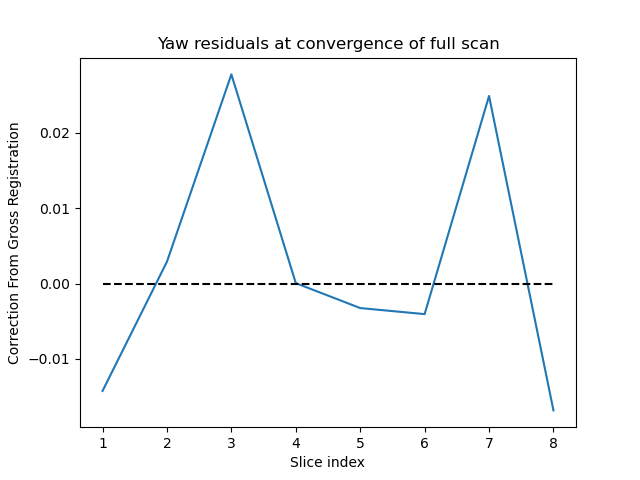

In [132]:
fig, ax = plt.subplots()
ax.set_xlabel('Slice index')
ax.set_ylabel('Correction From Gross Registration')
ax.set_title('Yaw residuals at convergence of full scan')
component = 0 #fwd translation
# component = -1 #yaw
good_idx = np.argwhere(traj_hist_scans_ij[:,component] != 0 )
# print(good_idx)
ax.plot(good_idx, traj_hist_scans_ij[good_idx,component])
ax.plot(good_idx, np.zeros(good_idx[-1] - good_idx[0] + 1), 'k--')

In [130]:
#run and visualize ICET again, just on the local slice
c1 = scan1_slices[6]
c2 = scan2_slices[6]
it2 = ICET(cloud1 = c1, cloud2 = c2, fid = binsize, niter = 10, 
           draw = True, group = 2, RM = True, DNN_filter = False)

print(it2.X)
print("pred_stds:", it2.pred_stds)

ViewInteractiveWidget(it2.plt.window)


 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([-0.00419707 -0.00963889  0.00450579 -0.0007928  -0.00029491 -0.00042825], shape=(6,), dtype=float32)
tf.Tensor([-0.00419707 -0.00963889  0.00450579 -0.0007928  -0.00029491 -0.00042825], shape=(6,), dtype=float32)
pred_stds: tf.Tensor(
[4.39151097e-03 6.11625053e-03 5.49798831e-04 9.83736973e-05
 1.04496015e-04 3.01045773e-04], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Get true transform using EgomotionProvider()

In [106]:
provider = pf.egomotion_provider
#for entire trajectory
time_range = provider.get_timestamps()
subsample = 1
traj1 = provider.get_trajectory(time_range, subsampling = subsample) #subsampling is inverted (100 is LOWER resolution)
# print(np.shape(traj1))
time_range = time_range[::subsample] #need to reduce time range if we subsample
# print(np.shape(time_range))

# fig,ax = plt.subplots()
# ax.set_aspect("equal")
# ax.plot(traj1[:,0,-1], traj1[:,1,-1])

T = np.eye(4)
x_hist_gt = np.zeros([len(traj1), 6])
for idx_i, i in enumerate(traj1):
#     print(i)
    T = T * i
#     print(T)
    x_hist_gt[idx_i,0] = T[0,-1] #E
    x_hist_gt[idx_i,1] = T[1,-1] #N
    x_hist_gt[idx_i,2] = T[2,-1] #U
    #get euler angles from rotation matrix
    euls = R.from_matrix(i[:3,:3]).as_euler('xyz', degrees=False)
    x_hist_gt[idx_i,3:] = euls

In [107]:
#get transform between two frames being considered
# t = pf['ouster64_bfc_xyzit'][idx].get_field('t')
time_range_test = provider.get_timestamps()
print(len(time_range_test))
# traj_local = provider.get_trajectory(t, subsampling = subsample)


1800


## plot results against ground truth

<IPython.core.display.Javascript object>


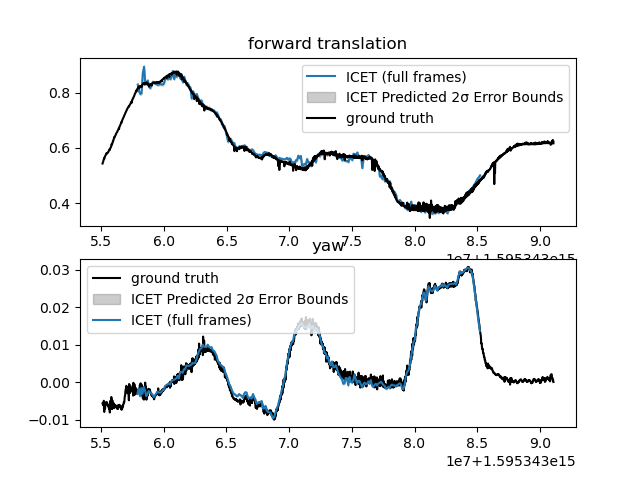

[2.23602518e-03 2.30074697e-03 1.79526920e-04 1.99071601e-05
 3.06149050e-05 1.21379722e-04]


In [108]:
fig, ax = plt.subplots(2,1)

# x_hist = np.loadtxt("leddartech_ICET_estimates.txt")
# pred_stds = np.loadtxt("leddartech_ICET_pred_stds.txt")

x_hist = np.loadtxt("results/leddartech_ICET_estimates_v2.txt")
pred_stds = np.loadtxt("results/leddartech_ICET_pred_stds_v2.txt") 
x_hist_NDT = np.loadtxt("results/leddartech_NDT_estimates.txt")

#get timestamp of first range return in LIDAR trajectory
ts_lidar = np.zeros(len(x_hist))
for c in range(len(x_hist)):
    ts_lidar[c] = pf['ouster64_bfc_xyzit'][c].get_field('t')[-1]

print(pred_stds[0])
ax[0].plot(ts_lidar, x_hist[:,0], label = 'ICET (full frames)')
# ax[0].plot(ts_lidar, x_hist_NDT[:,0], label = 'NDT')
ax[0].fill_between(ts_lidar, x_hist[:,0]+ 2*pred_stds[:,0], x_hist[:,0] - 2*pred_stds[:,0], 
                 color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
ax[0].plot(time_range[:-1], (5/subsample)*np.sqrt(np.diff(traj1[:,0,-1])**2 + np.diff(traj1[:,1,-1])**2),'k-', label = 'ground truth' ) #fwd
ax[0].set_title("forward translation")
ax[0].legend(loc = 'best')

ax[1].plot(time_range[1:], (5/subsample)*np.diff(x_hist_gt[:,-1]), 'k-', label = 'ground truth') #yaw
ax[1].fill_between(ts_lidar, x_hist[:,-1]+ 2*pred_stds[:,-1], x_hist[:,-1] - 2*pred_stds[:,-1], 
                 color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
ax[1].plot(ts_lidar, x_hist[:,5], label = 'ICET (full frames)')
ax[1].set_title("yaw")
ax[1].legend(loc = 'best')